<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Clasificación de texto con CNN<a id="top"></a>

<i><small>Última actualización: 2024-03-11</small></i></div>

***

## Introducción

En el procesamiento del lenguaje natural (NLP, del inglés natural language processing_), una tarea muy típica es la clasificación de textos. En esta tarea, un texto dado se clasifica según su significado. A menudo se utiliza, por ejemplo, para el problema del análisis de sentimientos.

Se trata de un problema denominado _many-to-one_, es decir, uno en el que el tamaño de la secuencia de entrada es $T_X = 1$, pero el tamaño de la secuencia de salida es $T_Y = 1$.

## Objetivos

Vamos a hacer un experimento en el que utilizaremos el conjunto de datos de reseñas de amazon para una tarea de análisis de sentimiento. A partir de los datos de reseñas y valoraciones, identificaremos si una reseña es positiva, neutra o negativa, y para ello utilizaremos una primera aproximación utilizando un modelo de redes neuronales convolucionales.

## Bibliotecas y configuración

A continuación importaremos las bibliotecas que se utilizarán a lo largo del cuaderno.

In [1]:
import os.path
import requests
from shutil import unpack_archive

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

2023-05-25 18:25:27.677882: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


También configuraremos algunos parámetros para adaptar la presentación gráfica.

In [2]:
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

Y crearemos los directorios necesarios en caso de que no se hayan creado previamente

In [3]:
os.makedirs('tmp', exist_ok=True)

***

## Parámetros globales

Comenzaremos definiendo los parámetros que utilizaremos a lo largo del cuaderno, que consistirán en la longitud máxima de las secuencias (recuerda que deben tener una longitud fija) y la dimensión del vector de cada palabra.

In [4]:
# Cuántas dimensiones tienen nuestros vectores de palabras (usaremos
# GloVe, así que 50, 100, 200 o 300)
EMBEDDING_DIM = 300
# Tamaño máximo de nuestro vocabulario (se elegirán los token más
# frecuentes)
MAX_VOCAB_SIZE = 16384
# Longitud máxima de las secuencias de palabras
MAX_SEQUENCE_LEN = 32

## Preprocesamiento de datos

Vamos a cargar los datos de entrenamiento, que consistirán en los datos de reseñas de Amazon de la categoría «Música digital» (https://nijianmo.github.io/amazon/index.html).

In [5]:
DATASET_URL = 'https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Digital_Music_5.json.gz'
DATASET_ZIP = 'tmp/Digital_Music_5.json.gz'

# Download the remote file if it does not exist
if not os.path.exists(DATASET_ZIP):
    with open(DATASET_ZIP, 'wb') as f:
        print(f'Downloading {DATASET_ZIP}...')
        r = requests.get(DATASET_URL, verify=False)
        f.write(r.content)
        print('OK')

corpus = pd.read_json(DATASET_ZIP, lines=True)
corpus.dropna(subset=['overall', 'reviewText'], inplace=True)
corpus.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5,3.0,True,"06 3, 2013",A2TYZ821XXK2YZ,3426958910,{'Format:': ' Audio CD'},Garrett,"This is awesome to listen to, A must-have for ...",Slayer Rules!,1370217600,NaN
1,5,NaN,True,"10 11, 2014",A3OFSREZADFUDY,3426958910,{'Format:': ' Audio CD'},Ad,bien,Five Stars,1412985600,NaN
2,5,NaN,True,"02 11, 2014",A2VAMODP8M77NG,3426958910,{'Format:': ' Audio CD'},JTGabq,It was great to hear the old stuff again and I...,SLAYER!!!!!!!!!!!!!!!!!!!!!,1392076800,NaN
3,4,3.0,False,"12 7, 2013",AAKSLZ9IDTEH0,3426958910,{'Format:': ' Audio CD'},john F&#039;n doe,well best of's are a bit poison normally but t...,slayer greatest hits! you mean everything righ...,1386374400,NaN
4,5,NaN,True,"06 12, 2016",A3OH43OZJLKI09,5557706259,{'Format:': ' Audio CD'},melinda a goodman,What can I say? This is Casting Crowns!!!This ...,"This is a good, blessing filled",1465689600,NaN


El proceso que realizaremos en este _notebook_ será ver cómo construir un modelo convolucional para trabajar con este tipo de conjuntos de datos. Por lo tanto no entraremos en el detalle de obtener un conjunto de datos de prueba.

Sin embargo, hay que tener en cuenta que en un problema real sería necesario entrenar con validación y contrastar con un conjunto de prueba antes de poner nuestro modelo en producción.

### Preparando la entrada a nuestro modelo

La entrada de nuestro modelo serán las reseñas como tales; por lo tanto, tomaremos la columna `reviewText` como nuestro conjunto de entrenamiento.

In [6]:
x_train = corpus['reviewText'].astype(str).str.strip()
print(f'Training input shape: {x_train.shape}')

Training input shape: (169623,)


Ahora crearemos una capa [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization), que se encargará de:

1. Convertir una reseña completa en una secuencia de enteros (palabras), asignando a cada palabra un valor único.
2. Truncar o rellenar las sencuencias para que estas mantengan una longitud fija previamente establecida (en nuestro caso `MAX_SEQUENCE_LEN`).

El vocabulario se extraerá de nuestra entrada, tomando las `MAX_VOCAB_SIZE` palabras más comunes. Hemos añadido `+ 2` a la longitud ya que hay dos tokens preasignados: Padding (`''`) y palabras fuera del vocabulario (`'[UNK]'`).

In [7]:
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE + 2,
    output_sequence_length=MAX_SEQUENCE_LEN,
)
vectorize_layer.adapt(x_train.to_numpy())

print(f'Vocabulary length: {len(vectorize_layer.get_vocabulary())}')

2023-05-25 18:25:33.556974: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-05-25 18:25:33.589490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:37:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-25 18:25:33.591575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:86:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2023-05-25 18:25:33.591614: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-05-25 18:25:33.595726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-05

Vocabulary length: 16386


### Preparando la salida de nuestro modelo

Partiendo de la base de que las reseñas con valoraciones altas serán positivas y las que tengan valoraciones bajas serán negativas, conservaremos sólo la reseña y la valoración del producto del conjunto de datos.

En concreto, convertiremos las valoraciones de las reseñas en 0 si son malas (1 o 2 estrellas), 1 si son mediocres (3 estrellas) y 2 si son buenas (4 o más estrellas).

In [8]:
y_train = corpus['overall'].astype(int).replace({
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 2,
})
print(f'Training output shape: {y_train.shape}')

Training output shape: (169623,)


## Uso de _embeddings_ preentrenados en nuestro modelo

Ya hemos visto que, a la hora de construir un modelo lingüístico, un aspecto importante es la representación de las palabras. Para captar el significado semántico de las palabras, utilizamos _embeddings_ de palabras, que son representaciones vectoriales de palabras en un espacio donde cada una de las muchas dimensiones representan una característica semántica.

Esta vez, en lugar de entrenar nuestros _embeddings_ desde cero, aprovecharemos uno preentrenado, _Global Vectors for Word Representation_ (GLoVe), entrenado con un conjunto de datos de más de 6.000 millones de tokens. Cuenta con varios vectores de palabras preentrenados, por lo que los utilizaremos en <http://nlp.stanford.edu/data/glove.6B.zip>.

In [9]:
GLOVE_URL = 'http://nlp.stanford.edu/data/glove.6B.zip'
GLOVE_FILE = 'tmp/glove.6B.zip'

# Download the compressed GloVe dataset (if you don't already have it)
if not os.path.exists(GLOVE_FILE):
    print('Downloading ...', end='')
    with open(GLOVE_FILE, 'wb') as f:
        r = requests.get(GLOVE_URL, allow_redirects=True)
        f.write(r.content)
    print('OK')

# Unzip it in the directory 'glove'.
print('Unpacking ...', end='')
unpack_archive(GLOVE_FILE, 'tmp')
print('OK')

Unpacking ...OK


Mediante su uso podemos aprovechar la gran cantidad de conocimiento codificado en estos _embeddings_, lo que seguramente mejore (y mucho)el rendimiento de nuestro modelo lingüístico.

Ahora carguemos el _embedding_ de la dimensión especificada en la configuración. El archivo se compone de líneas de tuplas, donde el primer elemento es la palabra (en texto) y el segundo es ese vector de palabras

In [10]:
print(f'Loading GloVe {EMBEDDING_DIM}-d embedding... ', end='')
word2vec = {}
with open(f'tmp/glove.6B.{EMBEDDING_DIM}d.txt') as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        word2vec[word] = np.fromstring(vector,'f', sep=' ')
print(f'done ({len(word2vec)} word vectors loaded)')

Loading GloVe 300-d embedding... 

Bueno, $400.000$ _tokens_ son bastantes. Como nuestro vocabulario es menor, vamos a crear una capa de incrustación más pequeña, del tamaño de nuestro vocabulario. Para ello, incluiremos en ésta sólo los vectores de las palabras que nos devolverá la capa `TextVectorization`.

Comenzaremos creando la matriz de incrustación con los vectores del guante

In [ ]:
print('Creating embedding matrix with GloVe vectors... ', end='')

# Our newly created embedding: a matrix of zeros
embedding_matrix = np.zeros((MAX_VOCAB_SIZE + 2, EMBEDDING_DIM))

ko_words = 0
for i, word in enumerate(vectorize_layer.get_vocabulary()):
    if word == '[UNK]':
        # The second word is for an unknown token, in glove is 'unk'
        word = 'unk'

    # Get the word vector and overwrite the row in its corresponding position
    word_vector = word2vec.get(word)
    if word_vector is not None:
        embedding_matrix[i] = word_vector
    else:
        ko_words += 1

print(f'done ({ko_words} words unassigned)')

Creating embedding matrix with GloVe vectors... done (3425 words unassigned)


Bueno, al parecer hay muchas palabras que no tienen correspondencia en el _embedding_ descargada. Después de todo $400000$ _tokens_ igual no eran tantos después de todo.

Una vez hecho esto, podemos crear una capa de incrustación con la matriz de pesos precargada.

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=embedding_matrix.shape[0],
    output_dim=embedding_matrix.shape[1],
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LEN,
    trainable=False,
    name='Embedding',
)

## Clasificación basada en redes neuronales convolucionales

Haremos una aproximación al problema utilizando redes convolucionales. En este caso, nuestras frases estarán representadas por «imágenes» de una sola fila, con tantas columnas como la longitud de la secuencia especificada y tantos canales como la dimensión de cada valabra de la secuencia.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,  # [[1, 2, 3, 4, 5], [6, 7, 8, 9, 0]]
    embedding_layer,
    tf.keras.layers.Conv1D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='sigmoid')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['sparse_categorical_accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_2 (TextVe (None, 32)                0         
_________________________________________________________________
Embedding (Embedding)        (None, 32, 300)           4915800   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            28832     
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 32)            128       
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 2883      
Total params: 4,947,643
Trainable params: 31,779
Non-trainable params: 4,915,864
_________________________________________

Entrenemos al modelo y esperemos que todo salga bien.

In [ ]:
history = model.fit(x_train, y_train, epochs=50)

2023-05-25 17:54:49.495306: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-05-25 17:54:49.514546: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1900000000 Hz


Epoch 1/5
5305/5305 [==============================] - 24s 4ms/step - loss: 0.1713 - sparse_categorical_accuracy: 0.9539
Epoch 2/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9593
Epoch 3/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9616
Epoch 4/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1210 - sparse_categorical_accuracy: 0.9638
Epoch 5/5
5305/5305 [==============================] - 22s 4ms/step - loss: 0.1137 - sparse_categorical_accuracy: 0.9653


Echemos un vistazo al progreso del entrenamiento:

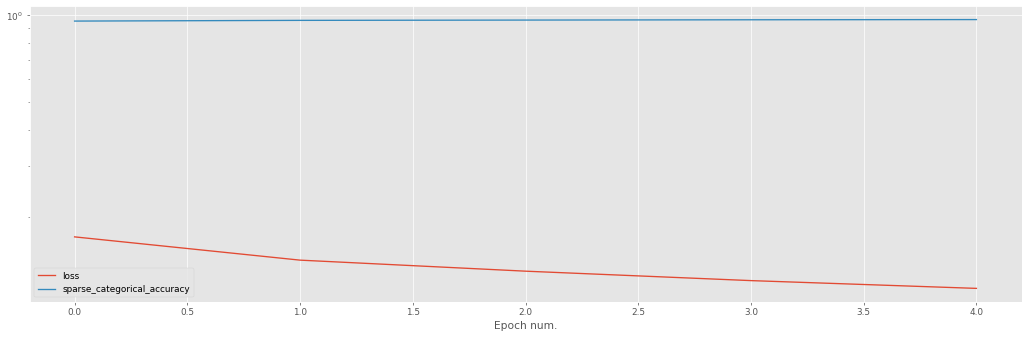

In [ ]:
pd.DataFrame(history.history).plot()
plt.yscale('log')
plt.xlabel('Epoch num.')
plt.show()

Veamos ahora cómo interpreta el sentimiento de una reseña buena, regular y mala extraída del sitio web de amazon.

In [ ]:
good = "My nephew is on the autism spectrum and likes to fidget with things so I knew this toy would be a hit. Was concerned that it may not be \"complex\" enough for his very advanced brain but he really took to it. Both him (14 yrs) and his little brother (8 yrs) both enjoyed playing with it throughout Christmas morning. I'm always happy when I can find them something unique and engaging."
poor = "I wasn't sure about this as it's really small. I bought it for my 9 year old grandson. I was ready to send it back but my daughter decided it was a good gift so I'm hoping he likes it. Seems expensive for the price though to me."
evil = "I just wanted to follow up to say that I reported this directly to the company and had no response. I have not gotten any response from my review. The level of customer service goes a long way when an item you purchase is defective and this company didn’t care to respond. No I am even more Leary about ordering anything from this company. I never asked for a refund or replacement since I am not able to return it. I’m just wanted to let them know that this was a high dollar item and I expected it to be a quality item. Very disappointed! I bought this for my grandson for Christmas. He loved it and played with it a lot. My daughter called to say that the stickers were peeling on the corners. I am not able to take it from my grandson because he is autistic and wouldn’t understand. I just wanted to warn others who are wanting to get this. Please know that this is a cool toy and it may not happen to yours so it is up to you."

probabilities = model.predict([good, poor, evil], verbose=0)
print(f'Good was classified as {np.argmax(probabilities[0])}')
print(f'Poor was classified as {np.argmax(probabilities[1])}')
print(f'Evil was classified as {np.argmax(probabilities[2])}')

Good was classified as 2
Poor was classified as 2
Evil was classified as 1


## Conclusiones

Hemos demostrado cómo utilizar una red neuronal convolucional para clasificar texto, en concreto, reseñas de productos como buenas, medias o malas. También hemos analizado las ventajas de utilizar incrustaciones de palabras preentrenadas, que pueden ayudar a mejorar el rendimiento del modelo aprovechando las relaciones semánticas entre las palabras del corpus preentrenado. También exploramos la capa TextVectorization, que proporciona una forma flexible de preprocesar datos de texto y convertirlos en vectores numéricos.

Se trata de un ejemplo que puede servir de punto de partida para multitud de proyectos de NLP.

***

<div><img style="float: right; width: 120px; vertical-align:top" src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" alt="Creative Commons by-nc-sa logo" />

[Volver al inicio](#top)

</div>